In [9]:
!pip install pandas openpyxl



In [44]:
!pip install --upgrade numpy statsmodels seaborn


  Obtaining dependency information for numpy from https://files.pythonhosted.org/packages/9b/0f/022ca4783b6e6239a53b988a4d315d67f9ae7126227fb2255054a558bd72/numpy-2.0.0-cp311-cp311-win_amd64.whl.metadata
     ---------------------------------------- 0.0/60.9 kB ? eta -:--:--
     ------ --------------------------------- 10.2/60.9 kB ? eta -:--:--
     ------ --------------------------------- 10.2/60.9 kB ? eta -:--:--
     ------------ ------------------------- 20.5/60.9 kB 129.6 kB/s eta 0:00:01
     -------------------------------------- 60.9/60.9 kB 322.7 kB/s eta 0:00:00


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np



# Read the Excel file
data = pd.read_csv("EastWestAirliness.csv")

data.head()



,ID#,Balance,Qual_miles,cc1_miles,cc2_miles,cc3_miles,Bonus_miles,Bonus_trans,Flight_miles_12mo,Flight_trans_12,Days_since_enroll,Award?
0,1,28143,0,1,1,1,174,1,0,0,7000,0
1,2,19244,0,1,1,1,215,2,0,0,6968,0
2,3,41354,0,1,1,1,4123,4,0,0,7034,0
3,4,14776,0,1,1,1,500,1,0,0,6952,0
4,5,97752,0,4,1,1,43300,26,2077,4,6935,1


# Data Preprocessing

In [2]:
# Checking for missing values
data.isnull().sum()


ID#                  0
Balance              0
Qual_miles           0
cc1_miles            0
cc2_miles            0
cc3_miles            0
Bonus_miles          0
Bonus_trans          0
Flight_miles_12mo    0
Flight_trans_12      0
Days_since_enroll    0
Award?               0
dtype: int64

In [3]:
# Handle missing values,
data.fillna(data.mean(), inplace=True)


In [4]:
# Identify numerical columns
numerical_cols = data.columns[1:]  # Exclude the ID# column

# Remove outliers using IQR method
Q1 = data[numerical_cols].quantile(0.25)
Q3 = data[numerical_cols].quantile(0.75)
IQR = Q3 - Q1

# Filtering out the outliers
filtered_data = data[~((data[numerical_cols] < (Q1 - 1.5 * IQR)) | (data[numerical_cols] > (Q3 + 1.5 * IQR))).any(axis=1)]


In [5]:
from sklearn.preprocessing import StandardScaler

# Scale the features
scaler = StandardScaler()
scaled_data = scaler.fit_transform(filtered_data[numerical_cols])

# Convert the scaled data back to a DataFrame
scaled_df = pd.DataFrame(scaled_data, columns=numerical_cols)

# Display the first few rows of the scaled data
scaled_df.head()


,Balance,Qual_miles,cc1_miles,cc2_miles,cc3_miles,Bonus_miles,Bonus_trans,Flight_miles_12mo,Flight_trans_12,Days_since_enroll,Award?
0,-0.438859,0.0,-0.719055,0.0,0.0,-0.783131,-1.081732,-0.378837,-0.409708,1.503693,-0.623072
1,-0.647735,0.0,-0.719055,0.0,0.0,-0.780130,-0.952735,-0.378837,-0.409708,1.488035,-0.623072
2,-0.128773,0.0,-0.719055,0.0,0.0,-0.494075,-0.694742,-0.378837,-0.409708,1.520330,-0.623072
3,-0.752607,0.0,-0.719055,0.0,0.0,-0.759268,-1.081732,-0.378837,-0.409708,1.480206,-0.623072
4,-0.714019,0.0,-0.719055,0.0,0.0,-0.795867,-1.210728,-0.378837,-0.409708,1.475312,-0.623072


# EDA

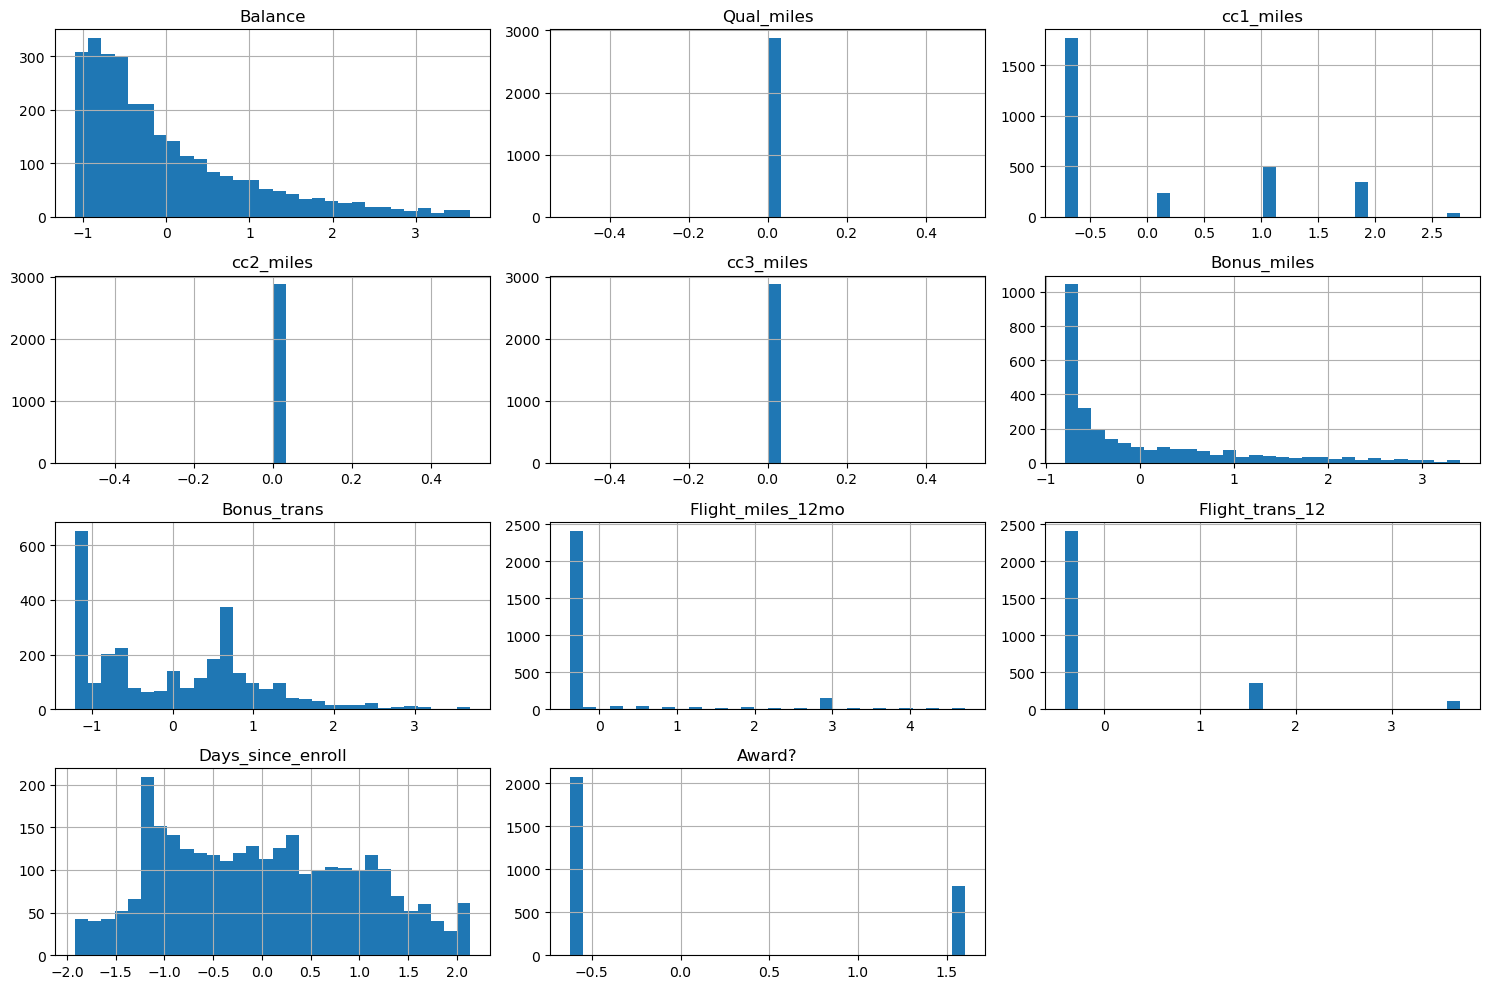

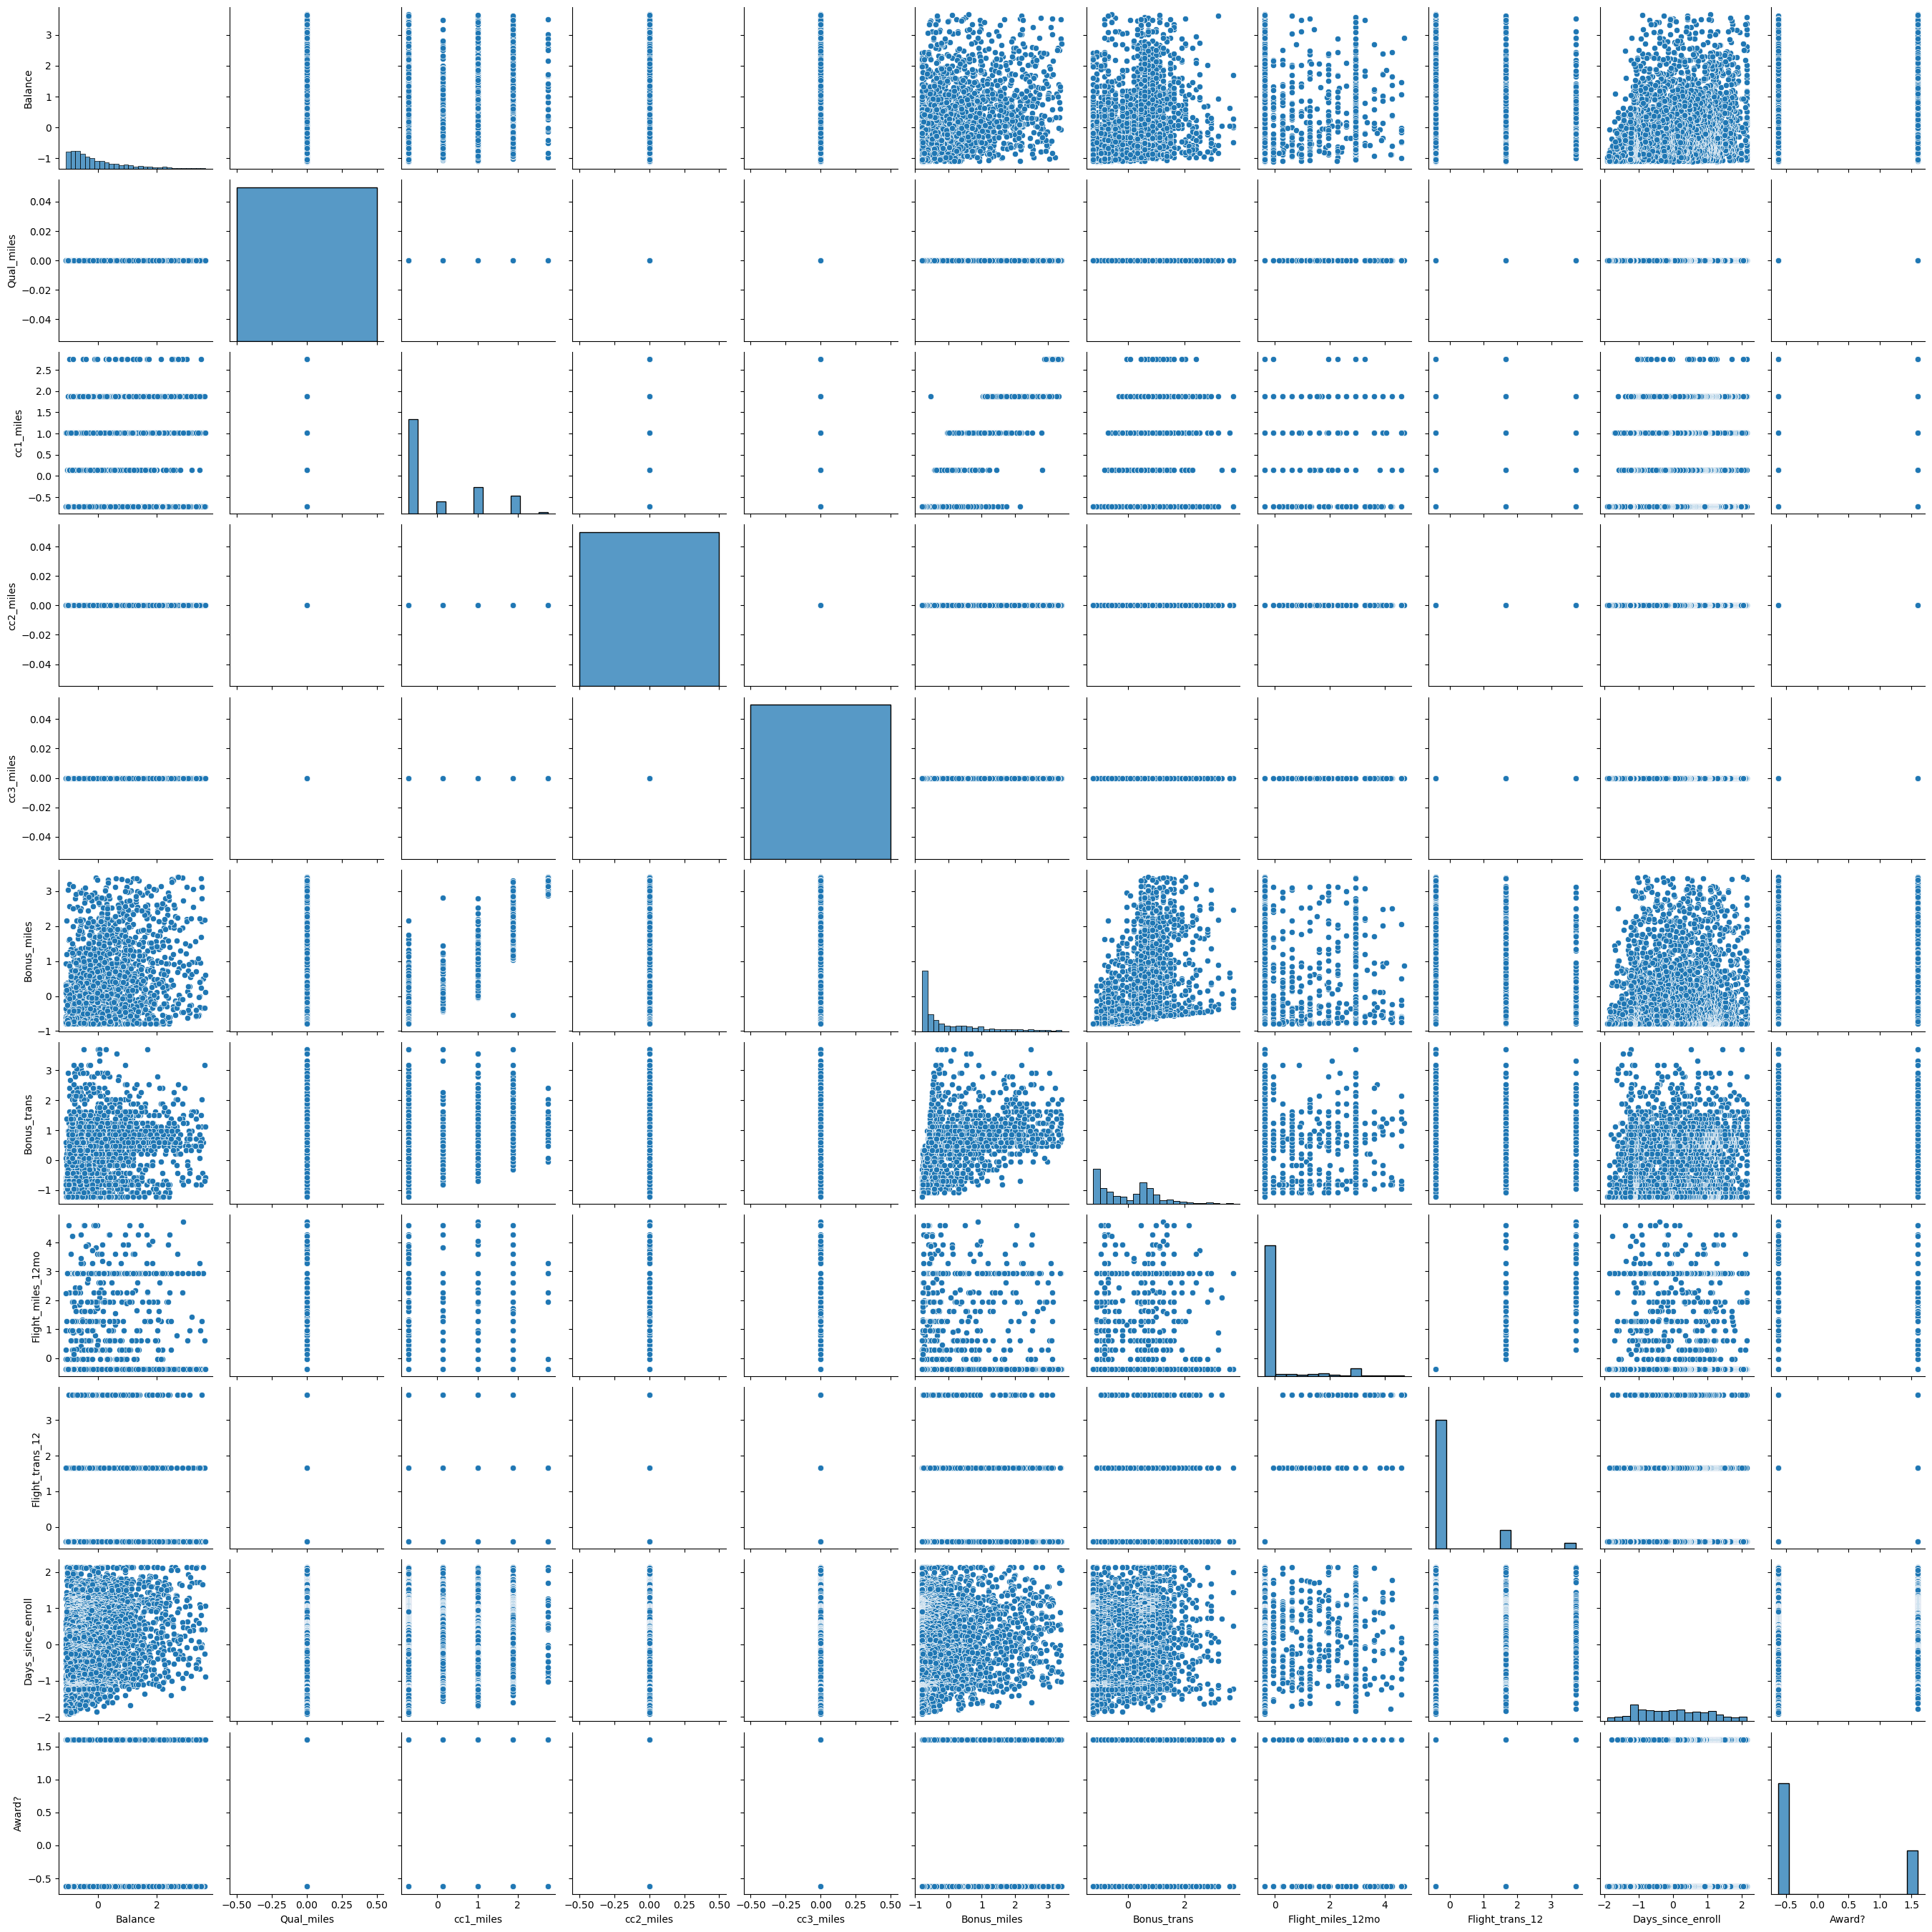

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Plot histograms for each feature
scaled_df.hist(figsize=(15, 10), bins=30, layout=(4, 3))
plt.tight_layout()
plt.show()

# Pair plot to understand the relationships
sns.pairplot(scaled_df)
plt.show()


# K-Means Clustering

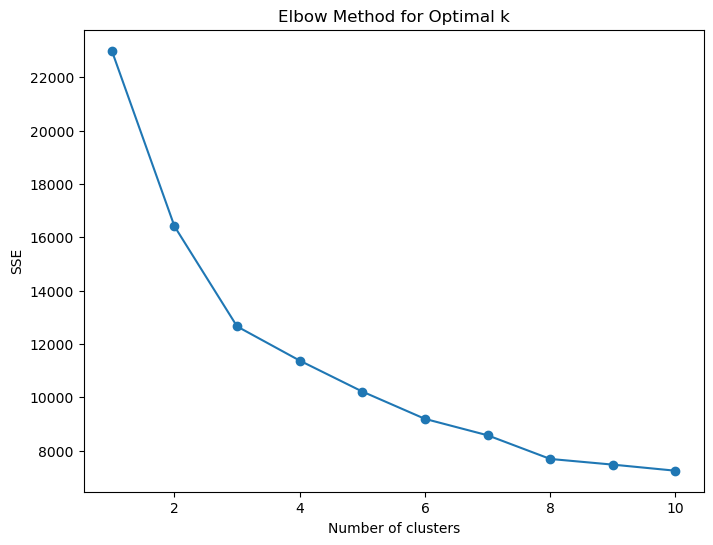

Silhouette Score for K-Means: 0.34184773367504273


In [7]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Determine the optimal number of clusters using the elbow method
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_df)
    sse.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), sse, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.title('Elbow Method for Optimal k')
plt.show()

# Apply K-Means with the optimal number of clusters
optimal_k = 3  # Replace with your chosen k
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans_labels = kmeans.fit_predict(scaled_df)

# Evaluate clustering performance
silhouette_avg = silhouette_score(scaled_df, kmeans_labels)
print(f'Silhouette Score for K-Means: {silhouette_avg}')


# Hierarchical Clustering


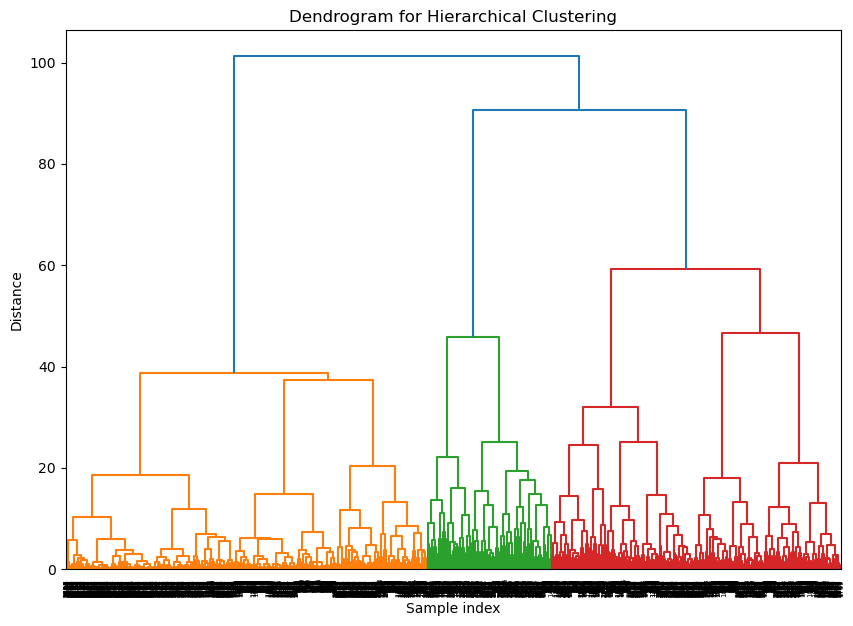

Silhouette Score for Hierarchical Clustering: 0.286027493721446


In [8]:
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

# Generate the linkage matrix
linkage_matrix = linkage(scaled_df, method='ward')

# Plot the dendrogram
plt.figure(figsize=(10, 7))
dendrogram(linkage_matrix)
plt.title('Dendrogram for Hierarchical Clustering')
plt.xlabel('Sample index')
plt.ylabel('Distance')
plt.show()

# Apply hierarchical clustering
hierarchical_labels = fcluster(linkage_matrix, t=optimal_k, criterion='maxclust')

# Evaluate clustering performance
silhouette_avg = silhouette_score(scaled_df, hierarchical_labels)
print(f'Silhouette Score for Hierarchical Clustering: {silhouette_avg}')


# DBSCAN Clustering

In [9]:
from sklearn.cluster import DBSCAN

# Apply DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(scaled_df)

# Evaluate clustering performance
silhouette_avg = silhouette_score(scaled_df, dbscan_labels)
print(f'Silhouette Score for DBSCAN: {silhouette_avg}')


Silhouette Score for DBSCAN: -0.12952372601527012


# Visualization

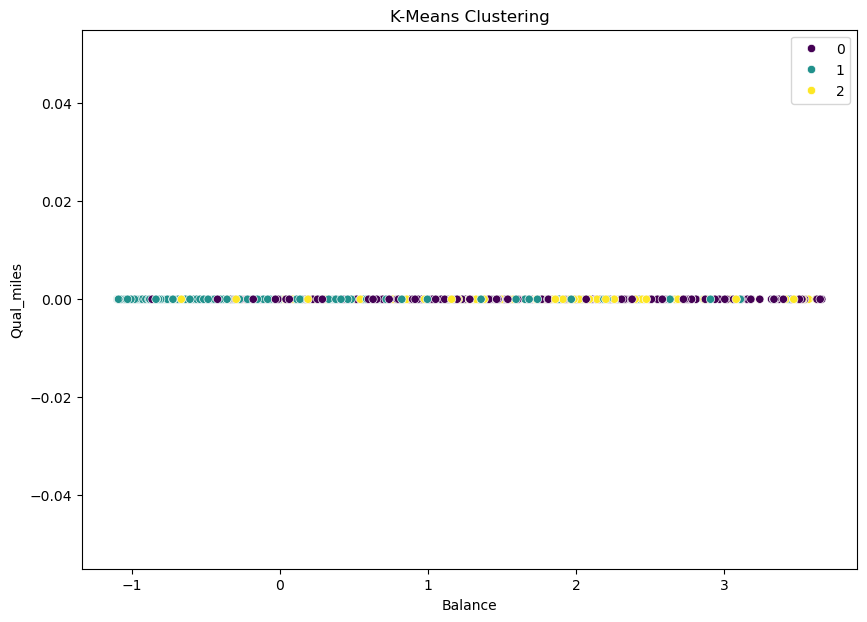

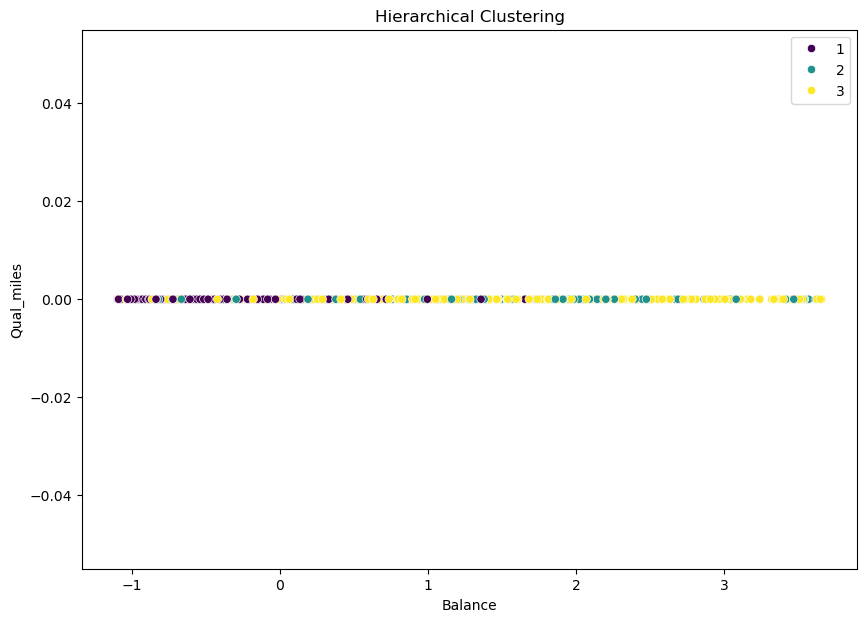

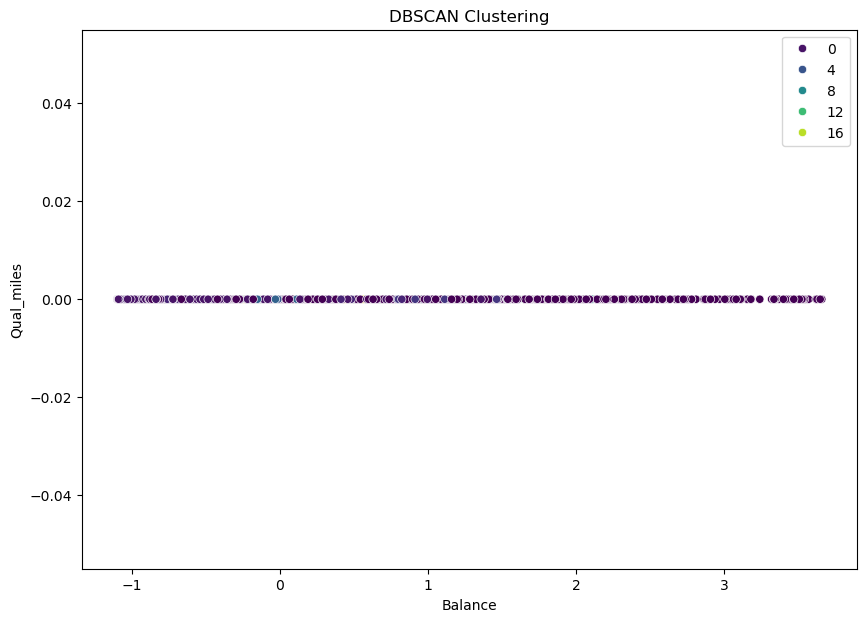

In [10]:
# Visualize K-Means clustering results
plt.figure(figsize=(10, 7))
sns.scatterplot(x=scaled_df.iloc[:, 0], y=scaled_df.iloc[:, 1], hue=kmeans_labels, palette='viridis')
plt.title('K-Means Clustering')
plt.show()

# Visualize Hierarchical clustering results
plt.figure(figsize=(10, 7))
sns.scatterplot(x=scaled_df.iloc[:, 0], y=scaled_df.iloc[:, 1], hue=hierarchical_labels, palette='viridis')
plt.title('Hierarchical Clustering')
plt.show()

# Visualize DBSCAN clustering results
plt.figure(figsize=(10, 7))
sns.scatterplot(x=scaled_df.iloc[:, 0], y=scaled_df.iloc[:, 1], hue=dbscan_labels, palette='viridis')
plt.title('DBSCAN Clustering')
plt.show()
